In [1]:
!pip install --upgrade pip
!pip install pandas scikit-learn matplotlib

In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.dummy import DummyClassifier

In [3]:
fontsize = 12
plt.rcParams.update({'font.size': fontsize})
cmap = matplotlib.colormaps['tab10']
blue = cmap(0)
green = cmap(2)
yellow = cmap(8)

## Class Distribution

In [5]:
classes = np.unique(np.load(os.path.join('Arrays', 'Donut', 'y_true.npy')))
classes

array(['credit_note', 'debit_note', 'order', 'proforma', 'purchase_order',
       'receipt', 'sales_order', 'tax_invoice', 'utility_bill'],
      dtype='<U14')

In [8]:
arrays = ['y_train', 'y_test', 'y_val']
y_true = np.concatenate([np.load(os.path.join('Arrays', f'{array}.npy')) for array in arrays])
y_true = np.array([classes[np.argmax(sample)] for sample in y_true])
y_true.shape

(19393,)

In [9]:
counts = pd.Series(y_true).value_counts(ascending=True)
counts

debit_note           7
utility_bill        18
proforma            33
credit_note         35
receipt           1121
sales_order       2122
purchase_order    3167
order             5605
tax_invoice       7285
Name: count, dtype: int64

In [10]:
classes_ger = ['Lastschrift', 'Strom- und\nGasrechnung', 'Proforma', 'Gutschrift', 'Beleg', 'Kunden-\nauftrag', 'Auftrags-\nbestätigung', 'Auftrag', 'Steuer-\nrechnung']
counts.index = classes_ger
counts

Lastschrift                   7
Strom- und\nGasrechnung      18
Proforma                     33
Gutschrift                   35
Beleg                      1121
Kunden-\nauftrag           2122
Auftrags-\nbestätigung     3167
Auftrag                    5605
Steuer-\nrechnung          7285
Name: count, dtype: int64

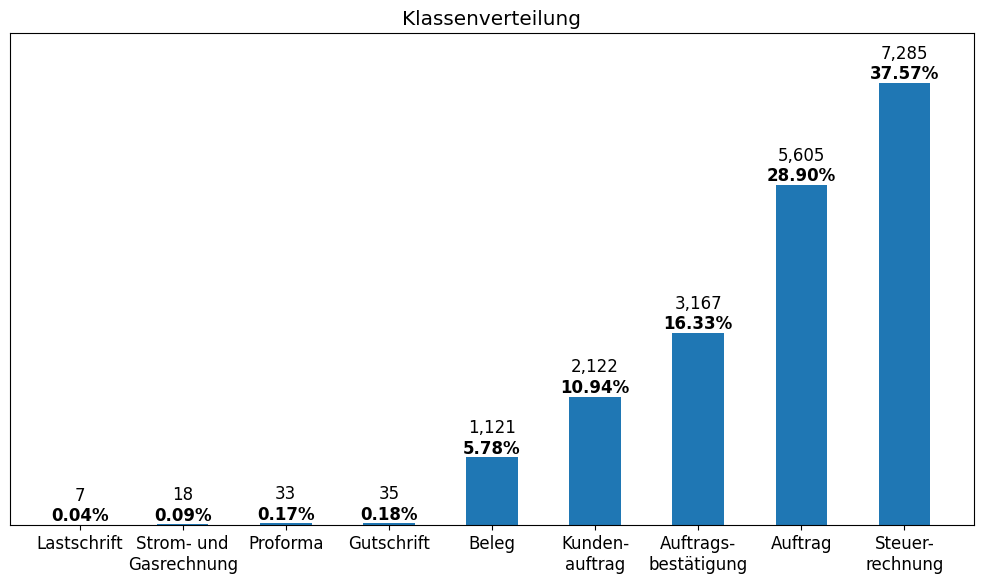

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(x=counts.index, height=counts.values, width=0.5)

# Displaying percentages above each bar
for i, count in enumerate(counts.values):
    perc = count / len(y_true) * 100
    plt.text(i, count + 400, f'{count:,}', ha='center', fontsize=fontsize, weight='normal')  # First row normal
    plt.text(i, count + 60, f'{perc:.2f}%', ha='center', fontsize=fontsize, weight='bold')  # Second row bold

plt.title('Klassenverteilung')
plt.ylim(0, 8100)
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join('Plots', 'class_distribution.png'), bbox_inches='tight')

plt.show()

## Baseline

### Dummy Classifier

In [25]:
strategies = ['most_frequent', 'stratified']
classifiers = ['Baseline\nMost\nFrequent Class', 'Baseline\nWeighted\nGuessing']
baselines = []

for strategy, classifier in zip(strategies, classifiers):
    clf = DummyClassifier(strategy=strategy, random_state=0)
    clf.fit(X=None, y=y_true)
    y_pred = clf.predict(y_true)
    balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    result = {
        'classifier': classifier,
        'type': 'DummyClassifier',
        'balanced_accuracy': balanced_accuracy
    }
    baselines.append(result)
    
baselines_df = pd.DataFrame(baselines)
baselines_df

,classifier,type,balanced_accuracy
0,Baseline\nMost\nFrequent Class,DummyClassifier,0.111111
1,Baseline\nWeighted\nGuessing,DummyClassifier,0.108908


In [ ]:
def evaluate(classifier, y_true, y_pred):
    balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    print(f'{classifier} balanced accuracy: {balanced_accuracy:.4f}')
    
    results.append(result)

### Zero Rate and Random Rate

In [149]:
def zero_rate(class_frequencies):
    return max(class_frequencies)

def random_rate(class_frequencies):
    return sum([class_frequency ** 2 for class_frequency in class_frequencies])

In [150]:
class_frequencies = pd.Series(y_true).value_counts(normalize=True).values
print(f'zero rate: {zero_rate(class_frequencies):.4f}')
print(f'random rate: {random_rate(class_frequencies):.4f}')

zero rate: 0.3756
random rate: 0.2666


## Donut Classification

In [151]:
# Load the predictions of the best donut model
donut_y_pred = np.load(os.path.join('Arrays', 'DonutClassification', f'10epochs_y_pred.npy')).tolist()
evaluate('Donut', y_true, donut_y_pred)

Donut balanced accuracy: 0.7918


In [152]:
pd.DataFrame(results)

,classifier,balanced_accuracy
0,Baseline\nMost\nFrequent Class,0.111111
1,Baseline\nWeighted\nGuessing,0.103505
2,Donut,0.791832


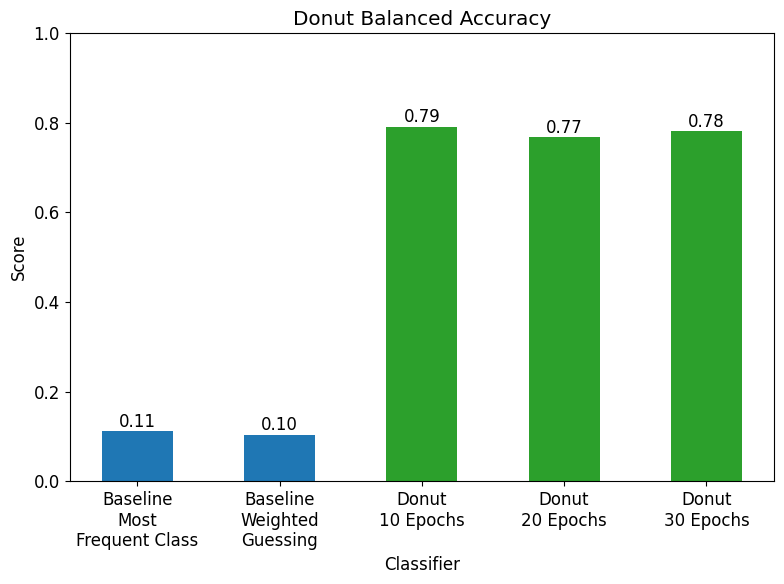

In [153]:
epoch_counts = ['10', '20', '30']
results_donut = []

for epochs in epoch_counts:
    y_pred = np.load(os.path.join('Arrays', 'DonutClassification', f'{epochs}epochs_y_pred.npy'))
    result = {
        'classifier': f'Donut\n{epochs} Epochs',
        'balanced_accuracy': metrics.balanced_accuracy_score(y_true, y_pred)
    }
    results_donut.append(result)
    
results_donut.insert(0, results[0])
results_donut.insert(1, results[1])
results_donut_df = pd.DataFrame(results_donut)

colors = [blue, blue, green, green, green]
plt.figure(figsize=(8, 6))
plt.bar(x=results_donut_df['classifier'], height=results_donut_df['balanced_accuracy'], width=0.5, color=colors)
plt.title('Donut Balanced Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.ylim(0, 1)

# Displaying percentages above each bar
for i, score in enumerate(results_donut_df['balanced_accuracy']):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontsize=fontsize, weight='normal')

plt.tight_layout()
plt.savefig(os.path.join('Plots', 'donut_balanced_accuracy.png'), bbox_inches='tight')
plt.show()

## VGG16 Classification

In [154]:
def evaluate_cnn(cnn):
    layers_versions = ['added_layer', 'all_layer']
    layers_versions_pretty = ['Added Layers', 'All Layers']
    epoch_counts = ['30', '50', '100']
    y_true = np.load(os.path.join('Arrays', cnn, f'y_test.npy'))
    y_true = [classes[np.argmax(sample)] for sample in y_true]
    results_cnn = []
    
    for layers, layers_pretty in zip(layers_versions, layers_versions_pretty):
        for epochs in epoch_counts:
            y_pred = np.load(os.path.join('Arrays', cnn, f'predictions_{layers}_{epochs}epochs_10_5.npy'))
            balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
            result = {
                'classifier': f'{cnn}\n{layers_pretty}\n{epochs} Epochs',
                'balanced_accuracy': balanced_accuracy
            }
            results_cnn.append(result)
    
    results_cnn.insert(0, results[0])
    results_cnn.insert(1, results[1])
    results_cnn_df = pd.DataFrame(results_cnn)
    
    colors = [blue, blue, green, green, green, yellow, yellow, yellow]
    plt.figure(figsize=(11, 6))
    plt.bar(x=results_cnn_df['classifier'], height=results_cnn_df['balanced_accuracy'], width=0.5, color=colors)
    
    plt.title(f'{cnn} Balanced Accuracy')
    
    plt.xlabel('Classifier')
    
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    # Displaying percentages above each bar
    for i, score in enumerate(results_cnn_df['balanced_accuracy']):
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontsize=fontsize, weight='normal')
    
    plt.tight_layout()
    plt.savefig(os.path.join('Plots', f'{cnn.lower()}_balanced_accuracy.png'), bbox_inches='tight')
    plt.show()

In [155]:
# Load the predictions of the best VGG16 model
vgg16_y_true = np.load(os.path.join('Arrays', 'VGG16', f'y_test.npy'))
vgg16_y_true = [classes[np.argmax(sample)] for sample in vgg16_y_true]
vgg16_y_pred = np.load(os.path.join('Arrays', 'VGG16', f'predictions_all_layer_50epochs_10_5.npy'))
evaluate('VGG16', vgg16_y_true, vgg16_y_pred)

VGG16 balanced accuracy: 0.9376


In [156]:
pd.DataFrame(results)

,classifier,balanced_accuracy
0,Baseline\nMost\nFrequent Class,0.111111
1,Baseline\nWeighted\nGuessing,0.103505
2,Donut,0.791832
3,VGG16,0.937553


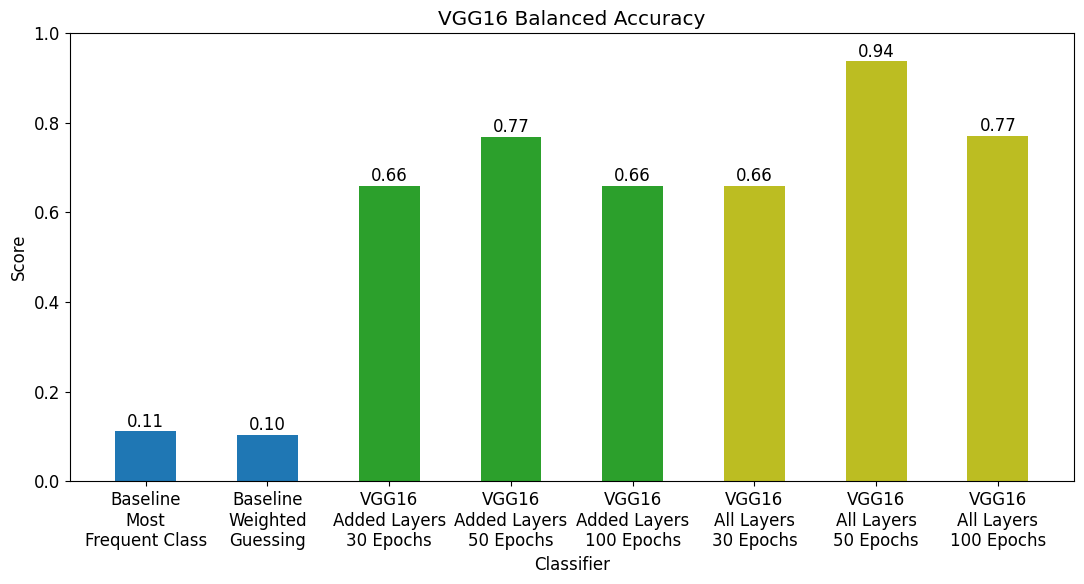

In [157]:
evaluate_cnn('VGG16')

## InceptionV3 Classification

In [158]:
# Load the predictions of the best InceptionV3 model
inceptionv3_y_true = np.load(os.path.join('Arrays', 'InceptionV3', f'y_test.npy'))
inceptionv3_y_true = [classes[np.argmax(sample)] for sample in inceptionv3_y_true]
inceptionv3_y_pred = np.load(os.path.join('Arrays', 'InceptionV3', f'predictions_all_layer_100epochs_10_5.npy'))
evaluate('InceptionV3', inceptionv3_y_true, inceptionv3_y_pred)

InceptionV3 balanced accuracy: 0.8850


In [159]:
pd.DataFrame(results)

,classifier,balanced_accuracy
0,Baseline\nMost\nFrequent Class,0.111111
1,Baseline\nWeighted\nGuessing,0.103505
2,Donut,0.791832
3,VGG16,0.937553
4,InceptionV3,0.885043


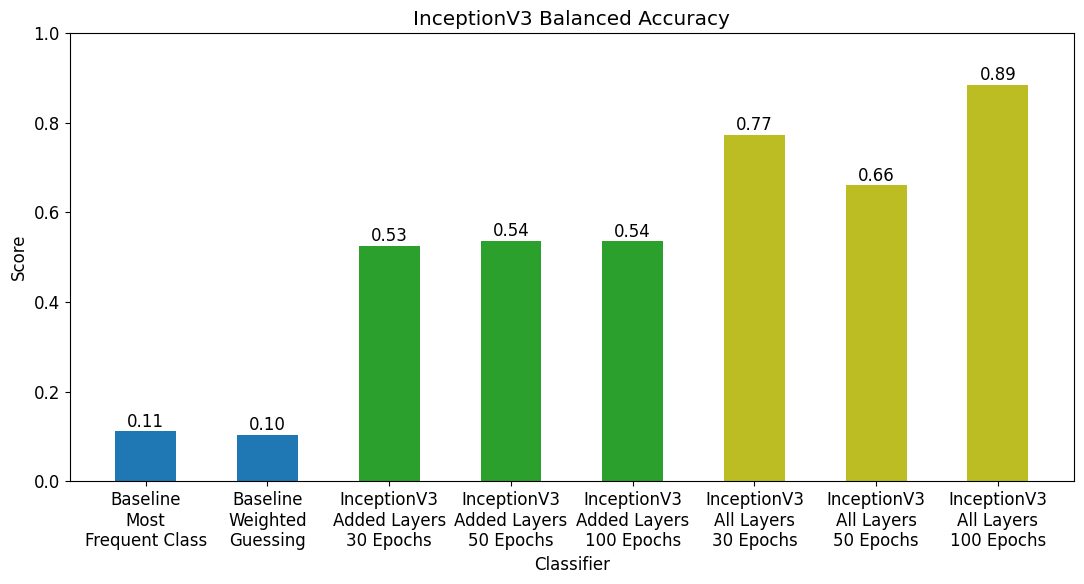

In [160]:
evaluate_cnn('InceptionV3')

## LayoutLMv3 Classification

In [161]:
# Load the predictions of the best LayoutLMv3 model
layoutlmv3_y_true = np.load(os.path.join('Arrays', 'LayoutLMv3', f'truelabels.npy'), allow_pickle=True)
layoutlmv3_y_pred = np.load(os.path.join('Arrays', 'LayoutLMv3', f'predictions_50Epochs.npy'), allow_pickle=True)
evaluate('LayoutLMv3', layoutlmv3_y_true, layoutlmv3_y_pred)

LayoutLMv3 balanced accuracy: 0.8036


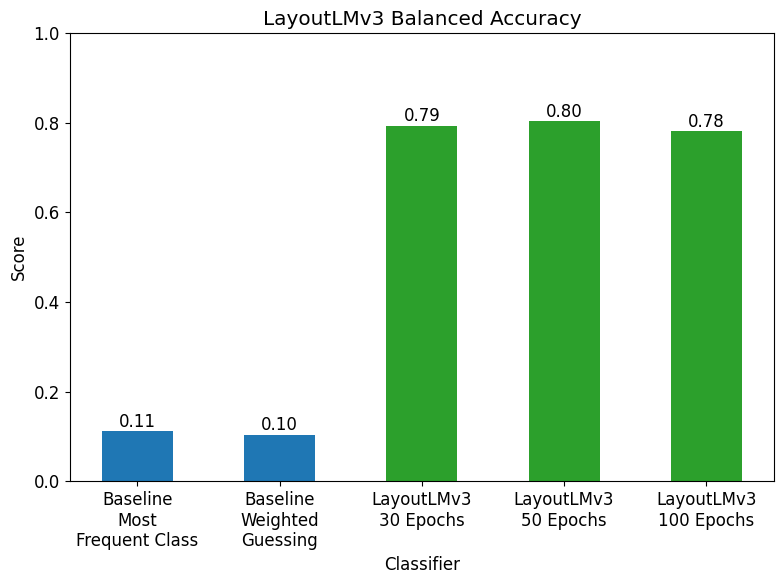

In [162]:
epoch_counts = ['30', '50', '100']
results_layoutlmv3 = []

for epochs in epoch_counts:
    y_pred = np.load(os.path.join('Arrays', 'LayoutLMv3', f'predictions_{epochs}Epochs.npy'))
    result = {
        'classifier': f'LayoutLMv3\n{epochs} Epochs',
        'balanced_accuracy': metrics.balanced_accuracy_score(layoutlmv3_y_true, y_pred)
    }
    results_layoutlmv3.append(result)
    
results_layoutlmv3.insert(0, results[0])
results_layoutlmv3.insert(1, results[1])
results_layoutlmv3_df = pd.DataFrame(results_layoutlmv3)

colors = [blue, blue, green, green, green]
plt.figure(figsize=(8, 6))
plt.bar(x=results_layoutlmv3_df['classifier'], height=results_layoutlmv3_df['balanced_accuracy'], width=0.5, color=colors)
plt.title('LayoutLMv3 Balanced Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.ylim(0, 1)

# Displaying percentages above each bar
for i, score in enumerate(results_layoutlmv3_df['balanced_accuracy']):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontsize=fontsize, weight='normal')

plt.tight_layout()
plt.savefig(os.path.join('Plots', 'layoutlmv3_balanced_accuracy.png'), bbox_inches='tight')
plt.show()

## Bar Chart

In [143]:
y_true = np.load(os.path.join('Arrays', 'DonutClassification', f'10epochs_y_real.npy'))
X = np.zeros((len(y_true), 1))
results = []
classes = np.unique(y_true)
classes

array(['credit_note', 'debit_note', 'order', 'proforma', 'purchase_order',
       'receipt', 'sales_order', 'tax_invoice', 'utility_bill'],
      dtype='<U14')

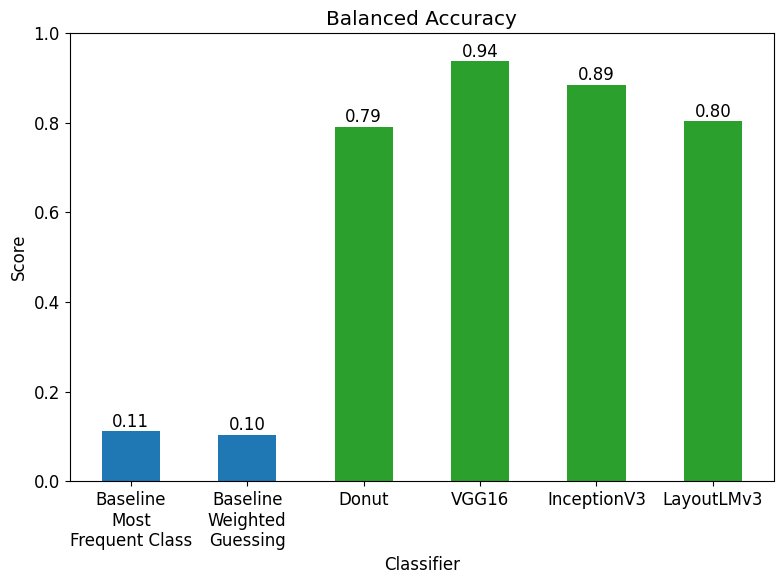

In [163]:
results_df = pd.DataFrame(results)

colors = [blue, blue, green, green, green, green]
plt.figure(figsize=(8, 6))
plt.bar(x=results_df['classifier'], height=results_df['balanced_accuracy'], width=0.5, color=colors)
plt.title('Balanced Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.ylim(0, 1)

# Displaying percentages above each bar
for i, score in enumerate(results_df['balanced_accuracy']):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontsize=fontsize, weight='normal')

plt.tight_layout()
plt.savefig(os.path.join('Plots', 'balanced_accuracy.png'), bbox_inches='tight')
plt.show()